# Kasus 2: Analisis Kapasitas Kontainer di Pelabuhan Korea Selatan

---

## 1a. Baca dataset menggunakan Pandas


In [1]:
import pandas as pd
import seaborn as sns

file_path = './2-kaggle-container-korea.csv'
df = pd.read_csv(file_path)

df.head()

,Unnamed: 0,Harbor,Date,isKorean,Full_10,Empty_10,Full_20,Empty_20,Full_40,Empty_40,Full_other,Empty_other,R/T
0,0,Busan,2018-01-01,True,165,273,61282,15753,59612,13995,147,67,3862353
1,1,Busan,2018-01-01,False,161,133,338680,74981,441504,83605,2879,705,26086071
2,2,Busan,2018-02-01,True,131,180,58404,14942,55317,12530,89,18,3507757
3,3,Busan,2018-02-01,False,197,130,329184,71048,440318,84009,3022,913,26385908
4,4,Busan,2018-03-01,True,90,176,62388,14732,59900,13404,94,116,3782328


## 1b. Data preprocessing

- Ekstraksi data bulan dan tahun
- Konversi ukuran kontainer ke dalam satuan TEU


In [2]:
# extract month and year
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# convert different container sizes into TEU
# assumption: Size "Other" is treated as TEU
_10_CONVERSION_FACTOR = 0.5
_40_CONVERSION_FACTOR = 2
OTHER_CONVERSION_FACTOR = 1

df['TEU_10'] = df[['Full_10', 'Empty_10']].sum(axis=1) * _10_CONVERSION_FACTOR
df['TEU_40'] = df[['Full_40', 'Empty_40']].sum(axis=1) * _40_CONVERSION_FACTOR
df['TEU_other'] = df[['Full_other', 'Empty_other']].sum(
    axis=1) * OTHER_CONVERSION_FACTOR

# get total capacity
df['capacity_teu'] = df[['TEU_10', 'Full_20',
                         'Empty_20', 'TEU_40', 'TEU_other']].sum(axis=1)

# preprocessed data
df.rename(columns={'Harbor': 'port_name'}, inplace=True)
df.head()
data = df.groupby(['port_name', 'year', 'month'])[
    'capacity_teu'].sum().reset_index()

data.head()

,port_name,year,month,capacity_teu
0,Busan,2018,1,1692292.0
1,Busan,2018,2,1662287.0
2,Busan,2018,3,1751716.0
3,Busan,2018,4,1787042.5
4,Busan,2018,5,1889075.0


## 2. Rata-rata kapasitas kontainer setiap pelabuhan per tahun


In [3]:
# modify pandas option to display floating-point numbers
pd.set_option('display.float_format', lambda x: '%.3f' % x)

avg_data = data.groupby(['port_name', 'year'])[
    'capacity_teu'].mean().reset_index()
avg_data.head()

,port_name,year,capacity_teu
0,Busan,2018,1799316.333
1,Busan,2019,1826905.583
2,Busan,2020,1794197.700
3,Daesan,2018,7567.917
4,Daesan,2019,6155.833


## 3. Pelabuhan dengan kapasitas kontainer tertinggi rata-rata setiap tahun.


In [4]:
max_avg_data = avg_data.loc[avg_data.groupby(
    'year')['capacity_teu'].idxmax()].reset_index(drop=True)
max_avg_data.rename(columns={'port_name': 'top_port_name'}, inplace=True)
max_avg_data = max_avg_data[['year', 'top_port_name', 'capacity_teu']]

max_avg_data.head()

,year,top_port_name,capacity_teu
0,2018,Busan,1799316.333
1,2019,Busan,1826905.583
2,2020,Busan,1794197.700


## 4. Visualisasi Tren Kapasitas Kontainer Bulanan

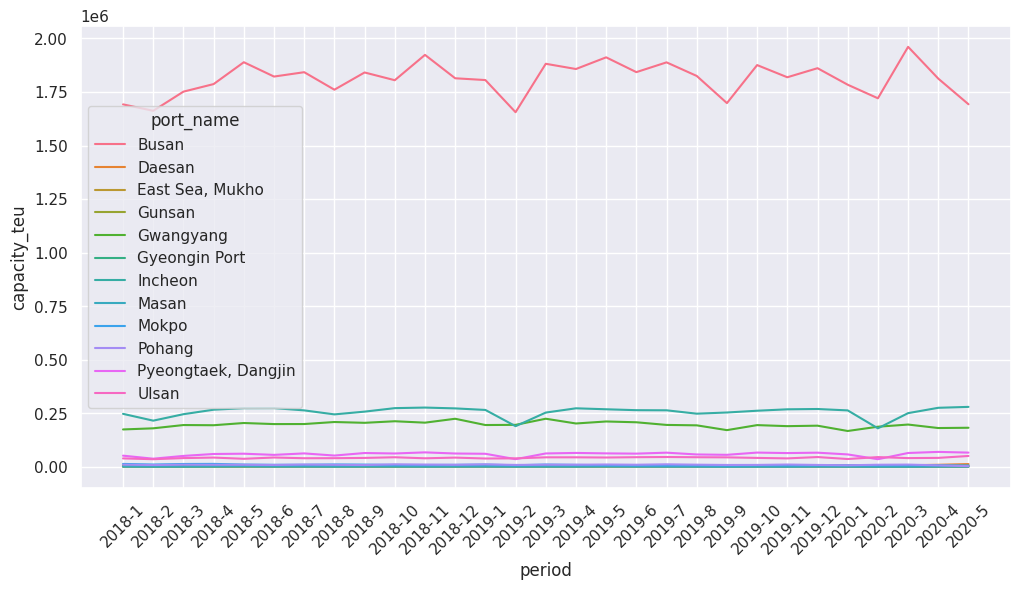

In [5]:
# get data source from the preprocessed data
vis_data = data
vis_data['period'] = vis_data['year'].astype(str) + '-' + vis_data['month'].astype(str)

# visualize data
sns.set_theme(rc={'figure.figsize':(12,6)})
plot = sns.lineplot(x=vis_data["period"], y=vis_data["capacity_teu"], hue=vis_data["port_name"], legend='full')
plot.tick_params(axis='x', labelrotation=45) 

## 5. Hasil analisis dalam CSV

In [6]:
# save two different dataframes to two separate csv files
avg_data.to_csv('./results/1_port_analysis_results_average_capacity.csv', index=False)
max_avg_data.to_csv(
    './results/2_port_analysis_results_max_average_capacity.csv', index=False)